# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [18]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [19]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [20]:
copy = data.copy()
copy['totals'] = data[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']].sum(axis=1)

totals = copy['totals']
print(totals.max(axis=0))
print(totals.idxmax(axis=0))
print(totals.min(axis=0))
print(totals.idxmin(axis=0))

mean_total = totals.mean()
print(mean_total)
total_closest_to_mean = min(totals, key=lambda x:abs(x-mean_total))
print(total_closest_to_mean)
index_closest_to_mean = totals[totals == total_closest_to_mean]
print(index_closest_to_mean)

# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [154, 1, 85]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

199891
85
904
154
33226.1363636
33266
1    33266
Name: totals, dtype: int64
Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,622,55,137,75,7,8
1,7057,9810,9568,1762,3293,1776
2,16117,46197,92780,1026,40827,2944


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:** Customer 0 looks more likely to be a large family or a smaller retail establishment. Considering the high proportion towards 'Fresh', it might be something like a farmers market or juice bar. Customer 1 purchases relatively evenly across the categories compared to the other customers. The highest being 'Milk'. This could be a large market specializing in dairy products. Could also be a breakfast establishment considering the high consumption in milk. Customer 2 has the highest consumption in 'Grocery' which makes it likely to be a conventional large grocery store.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [21]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
remove_feature = 'Delicatessen'
new_data = data.drop(remove_feature, axis=1)

# TODO: Split the data into training and testing sets using the given feature as the target
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data, data[remove_feature], test_size=0.25, random_state=1)

# TODO: Create a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=1)
regressor.fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print(score)

-0.429125195659


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:**
The feature with the highest coefficient score is 'Detergents_Paper'. This seems to be highly correlated to the rest of the features. This means that the other features align with 'Detergents_Paper', so removing it wouldn't be a big information loss. 'Fresh' and 'Delicatessen' have negative models which mean that the rest of the features don't explain these features. So these are necessary in properly modeling the data.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

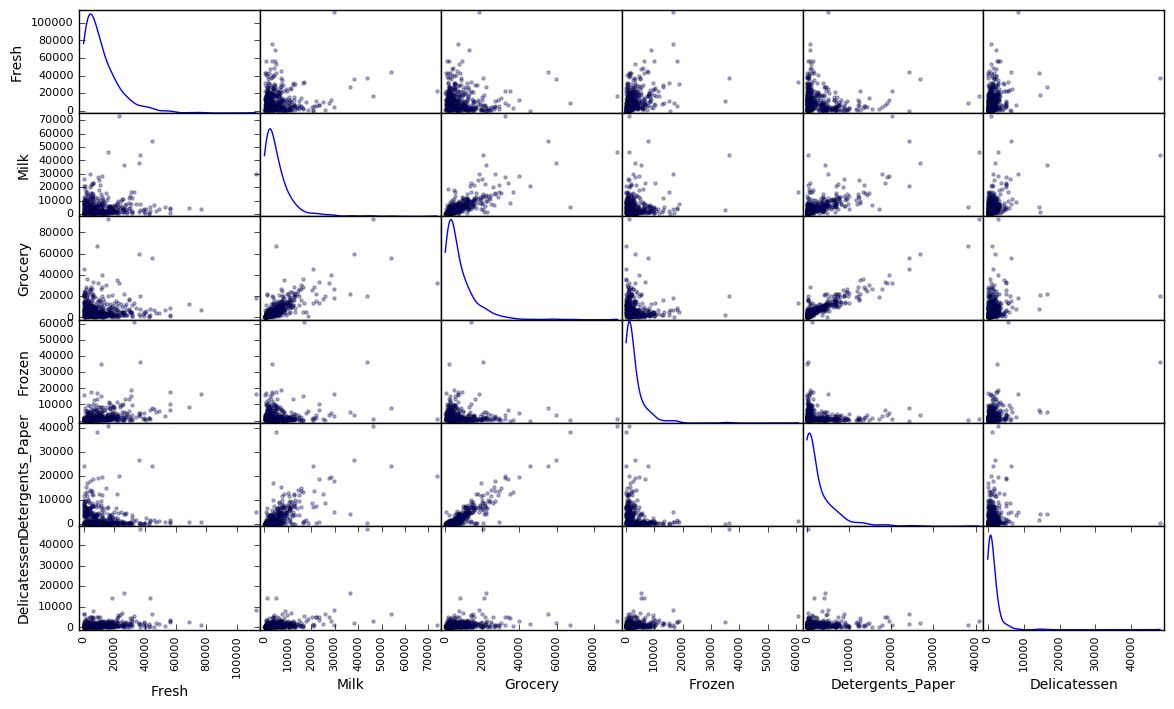

In [22]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:** For the most part the scatter matrix agrees with my assessment on 'Detergents_Paper'. It indeed shows correlation with several features making it less relevant for identifying a specific customer. The scatter matrix also seems to indicate 'Delicatessen' has a low correlation to all features, making it very relevant to identifying customer segements. 'Fresh' is similar too, but to a lesser degree.

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying logarithmic scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, use `np.log`.

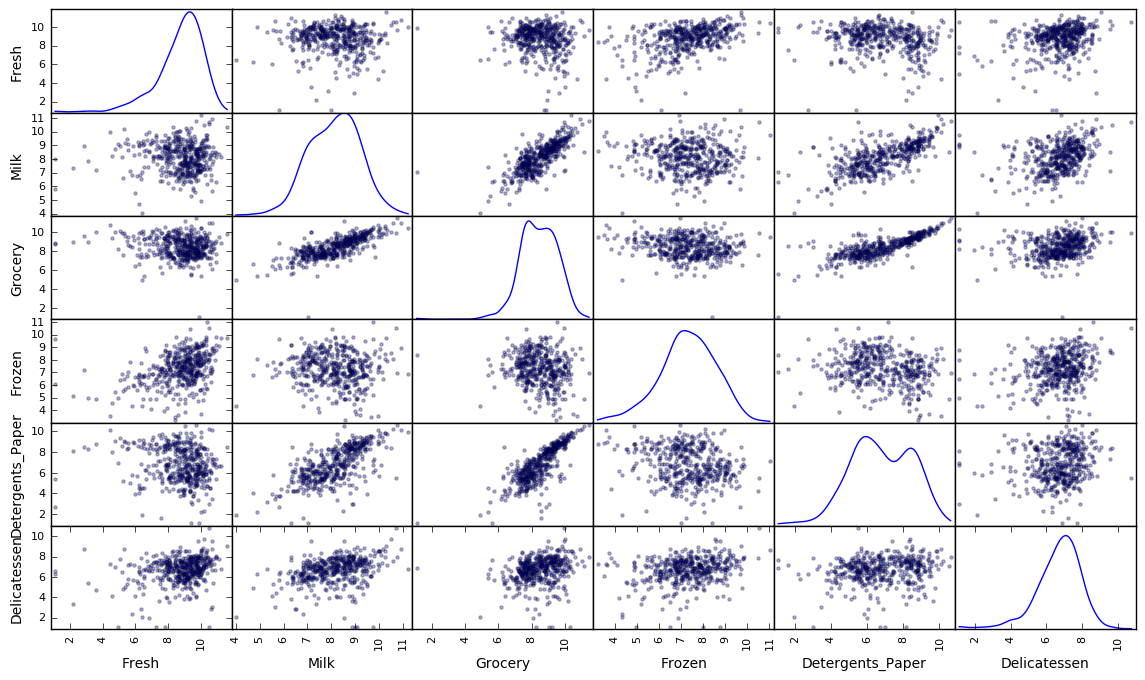

In [23]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data).copy()

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples).copy()

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [24]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,9.687630,10.740670,11.437986,6.933423,10.617099,7.987524


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [25]:
# For each feature find the data points with extreme high or low values
outliers = []
for feature in log_data.keys():
    q1, q3 = np.percentile(log_data[feature], [25, 75])
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = q1
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = q3
    iqr = Q3 - Q1
    tukeys = iqr * 1.5
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = tukeys / 2
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    
    # OPTIONAL: Select the indices for data points you wish to remove
    outlier_data = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    remove_indicies = outlier_data.index.values
    print "Indicies to remove '{}'".format(remove_indicies)
    outliers.append(remove_indicies)

outliers = [outlier for feature_outliers in outliers for outlier in feature_outliers]
unique = set(outliers)
for unique_outlier in unique:
    if unique_outlier in outliers:
        outliers.remove(unique_outlier)
        
        
outliers = list(set(outliers))
print outliers
print "Number of outliers for more than on feature: '{}'".format(len(outliers))

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
35,6.533789,8.610866,9.313889,6.725034,8.352083,6.077642
43,6.445720,9.314250,10.085726,6.668228,9.162095,4.276666
53,6.196444,9.256556,9.352881,6.612041,8.632484,5.411646
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
76,6.575076,8.185071,8.784468,8.926650,6.270988,6.795706
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
97,5.998937,5.537334,6.413459,6.651572,3.988984,4.143135


Indicies to remove '[ 35  43  53  65  66  76  81  95  96  97  98 125 128 154 159 170 171 173
 174 181 182 184 189 193 203 218 266 272 275 284 299 304 305 327 338 340
 342 352 353 355 357 358 359 392 412 418]'
Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
23,10.180096,10.502956,9.999661,8.547528,8.374938,9.712509
47,10.702480,10.901524,10.925417,8.959569,10.092909,8.774158
56,8.318254,10.305346,10.198617,7.869402,9.783577,7.200425
61,10.489662,10.555005,10.995377,8.087640,10.192456,7.609367
85,9.687630,10.740670,11.437986,6.933423,10.617099,7.987524
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
92,9.126741,10.220923,10.374553,8.080856,9.847235,8.542861
97,5.998937,5.537334,6.413459,6.651572,3.988984,4.143135
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
122,9.410174,5.303305,5.501258,7.596392,3.218876,6.756932


Indicies to remove '[ 23  47  56  61  85  86  92  97  98 122 154 171 181 183 191 211 219 238
 247 251 265 269 289 319 338 356 369]'
Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
47,10.702480,10.901524,10.925417,8.959569,10.092909,8.774158
61,10.489662,10.555005,10.995377,8.087640,10.192456,7.609367
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
85,9.687630,10.740670,11.437986,6.933423,10.617099,7.987524
97,5.998937,5.537334,6.413459,6.651572,3.988984,4.143135
122,9.410174,5.303305,5.501258,7.596392,3.218876,6.756932
131,7.650169,6.378426,5.749393,5.846439,4.248495,5.736572
148,8.686767,6.369901,6.295266,8.306966,5.645447,6.073045
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Indicies to remove '[ 47  61  65  75  85  97 122 131 148 154 161 211 216 228 237 238 247 275
 289 333 356 367 398]'
Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
16,6.927558,9.084324,9.402695,4.897840,8.413609,6.984716
25,9.690604,8.349957,8.935245,5.303305,8.294799,4.043051
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
42,9.291920,8.929965,9.613202,5.236442,8.839132,3.828641
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
59,8.722091,8.586719,8.992184,4.859812,8.033983,7.379632
60,9.058354,8.021256,8.968778,4.564348,8.317522,5.416100
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837


Indicies to remove '[  0  16  25  38  42  57  59  60  65  66  93  94  96 103 106 125 128 138
 144 145 154 175 181 183 184 196 216 221 264 277 310 325 333 334 338 353
 357 363 379 401 402 403 412 413 418 420 425 427 429 431 435 439]'
Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
85,9.687630,10.740670,11.437986,6.933423,10.617099,7.987524
122,9.410174,5.303305,5.501258,7.596392,3.218876,6.756932
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101
177,9.453992,8.899731,8.419139,7.468513,2.995732,7.875119
204,7.578657,6.792344,8.561401,7.232010,1.609438,7.191429
237,9.835851,8.252707,6.385194,8.441176,3.332205,7.102499
289,10.663966,5.655992,6.154858,7.235619,3.465736,3.091042


Indicies to remove '[ 75  85 122 142 154 161 177 204 237 289 333 338 356 402]'
Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
23,10.180096,10.502956,9.999661,8.547528,8.374938,9.712509
24,10.027783,9.187686,9.531844,7.977625,8.407825,8.661813
25,9.690604,8.349957,8.935245,5.303305,8.294799,4.043051
40,10.086850,8.373785,8.467372,9.160099,7.043160,8.676587
42,9.291920,8.929965,9.613202,5.236442,8.839132,3.828641
43,6.445720,9.314250,10.085726,6.668228,9.162095,4.276666
44,9.176784,8.857515,9.256365,6.293419,8.437717,4.174387
47,10.702480,10.901524,10.925417,8.959569,10.092909,8.774158
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837


Indicies to remove '[  2  23  24  25  40  42  43  44  47  66  71  84  87  88  97  98 109 128
 137 142 154 171 181 183 184 187 190 191 202 203 207 218 219 233 270 285
 286 289 303 311 318 325 343 355 357 375 412 439]'
[128, 43, 439, 142, 402, 275, 23, 25, 154, 412, 289, 418, 42, 171, 47, 181, 183, 184, 61, 191, 65, 66, 203, 325, 353, 75, 333, 338, 211, 85, 216, 218, 219, 96, 97, 98, 355, 356, 357, 161, 237, 238, 247, 122, 125]
Number of outliers for more than on feature: '45'


### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:** Using Tukey's 1.5 IQR, there are 45 data points that are considered outliers for more thant one feature. In order to avoid overfitting to the training data, it is appropriate to remove data points that are outliers for multiple features.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

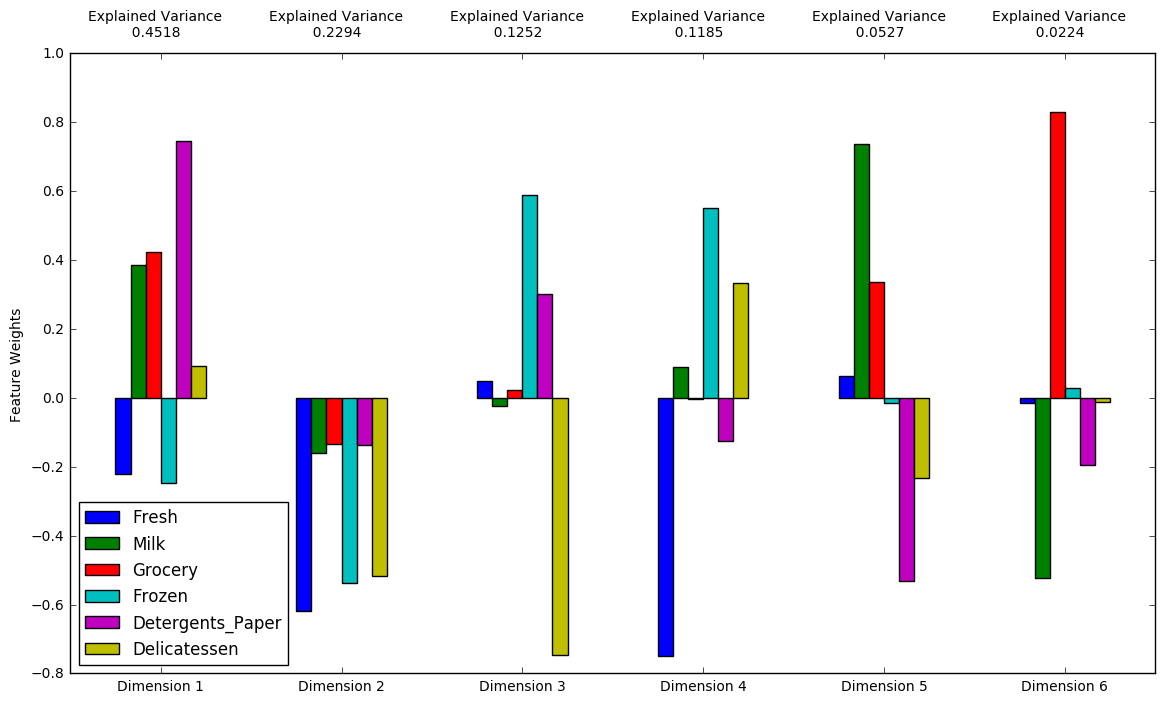

In [26]:
from sklearn.decomposition import PCA

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=6)
pca.fit(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the individual feature weights.

**Answer:** The first and second principal component represent 0.6812 variance. The first four represent 0.9242 variance. 

Individual feature correlations that have the absolute value of 0.5 or higher are considered important correlations. For Dimension 1, Detergents_Paper has the strongest weight. This makes Dimension 1 very much an indicator for the customer segment that purchases Detergents_Paper.

For Dimension 2, Fresh, Frozen and Delicatessen are significant. This indicates that if one of the features increase, these three features are likely to increase together. Dimension 2 is a measure of Fresh, Frozen and Delicatessen purchasing patterns.

Dimension 3 correlates strongly with Delicatessen. With the Frozen feature having a significant negative correlation, this dimension is in an indicator of buying Delicatessen and not buying Frozen.

Finally, the variance explained by Dimension 4 is a negative indicator of purchasing Fresh. However it also correlates the purchasing Frozen. Unlike dimension 2, this component suggests that customers that don't purchase Fresh are also likely to purchase Frozen.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [27]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-5.8791,7.3488,0.1376,-1.1731,-0.6641,0.1937
1,1.6849,-0.8813,-0.1030,0.2257,0.1725,-0.2052
2,5.1169,-2.2617,0.0135,-0.7061,0.6866,0.3424


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the results to `reduced_data`.
 - Apply a PCA transformation of `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [28]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [29]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-5.8791,7.3488
1,1.6849,-0.8813
2,5.1169,-2.2617


## Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

Run the code cell below to produce a biplot of the reduced-dimension data.

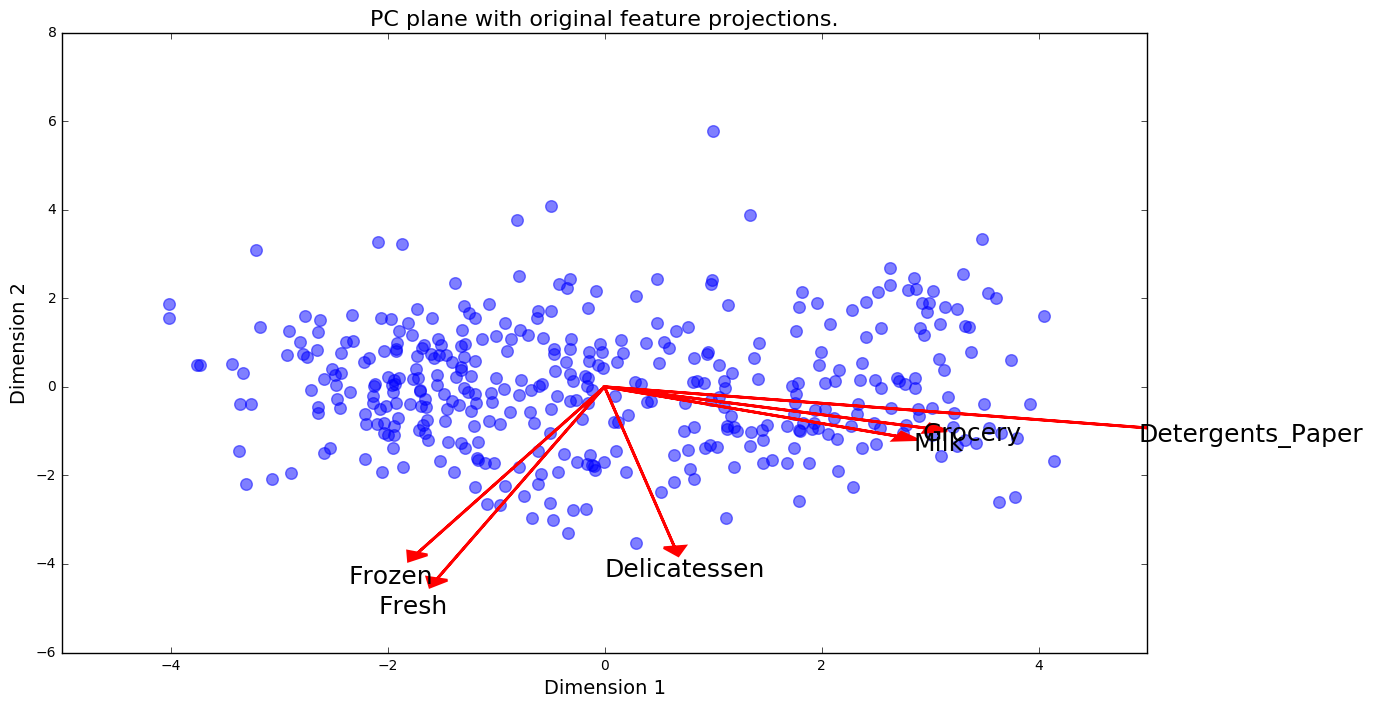

In [30]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:** 
K-Means results in absolute clustering. Data points must belong in one cluster. Also converges to a finite solution.

The Gaussian Mixture Model is advantageous for being more real world-like because it assigns probabilities to the data points rather than absolutetly categorizing the data point. Data points can have similar probabilities of being in multiple clusters.

I will use the Gaussian Mixture Model. K-Means can create counterintuitive clusterings based on the initial placement of the cluster centers. Rather that just labeling the data point to be in a customer segment, getting the probability of the data point to be in a specific cluster would be more insightful for real world application.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import `sklearn.metrics.silhouette_score` and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [31]:
from sklearn.mixture import GaussianMixture

# TODO: Apply your clustering algorithm of choice to the reduced data 
clusterer = GaussianMixture(n_components=2)
clusterer.fit(reduced_data)

# TODO: Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# TODO: Find the cluster centers
centers = clusterer.means_

# TODO: Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

from sklearn.metrics import silhouette_score
# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)
print(score)

0.450001465093


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**
2: 0.4500

3: 0.3623

4: 0.3273

5: 0.3681

6: 0.3469

25: 0.2557

100: 0.2961

2 clusters had the best silhouette score (0.4500).

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

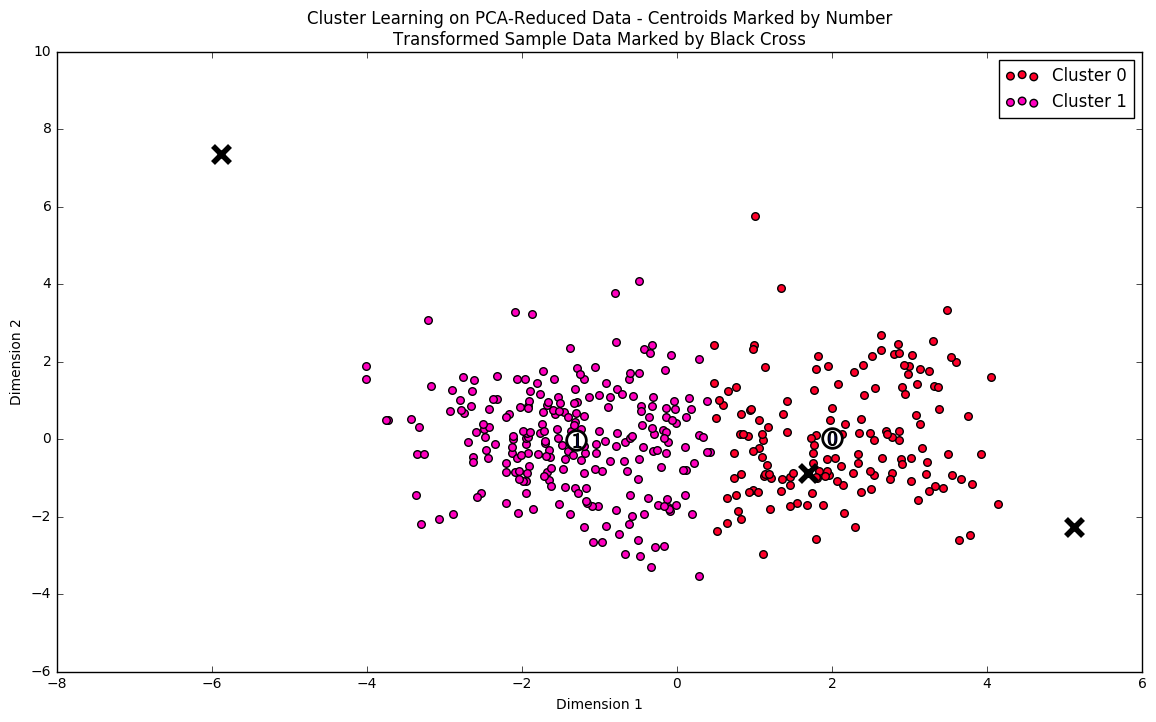

In [32]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [38]:
# TODO: Inverse transform the centers
print(centers)
log_centers = pca.inverse_transform(centers)
print(log_centers)
# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)
print(true_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

[[ 2.00198918  0.03412188]
 [-1.2972332  -0.02211003]]
[[ 8.38495712  8.91014615  9.29364277  6.84998425  8.31990677  6.92419396]
 [ 9.14675399  7.64782816  7.90251346  7.69229059  5.87165598  6.64924566]]
[[  4380.67071475   7406.7434932   10868.70423207    943.86604493
    4104.77728281   1016.57453844]
 [  9383.93051677   2096.08828094   2704.07037327   2191.38839593
     354.83609569    772.20160045]]


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,4381.0,7407.0,10869.0,944.0,4105.0,1017.0
Segment 1,9384.0,2096.0,2704.0,2191.0,355.0,772.0


### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:** Cluster center 'Segment 0', has high spending in 'Grocery' which is a good indicator of a grocery store establishment. The low spending on 'Frozen' could indicate that the establishment could be an organic grocery store. Based on the volume of spending, this also represents mid to large size establishments. 

Cluster center 'Segment 1' has a high spending in 'Fresh' which could represent a farmers market establishment. The volume also indicates that this cluster represents mid to small size establishments. Juice bar, breakfast restaurant are also establishments that were mentioned above that are represented by this cluster.

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [39]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 0


**Answer:** All three sample point predictions are consistent with the segmentation done in Q8. Sample point 0 follows the characteristics of smaller volume with relatively more spending in 'Fresh'. This aligns with the small business customer segment with specialization in fresh food, such as a juice bar. Sample point 1 and 2 also share the characteristics of the cluster in Q8. Such are high spending in 'Grocery' but also non-trivial spending in other categories. Both also have the lowest spending in 'Frozen'. Both seem to be commercial grocery stores (possibly organic) at different scales.

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. *How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*  
**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:** Changing the delivery service will impact customer segments differently. Through the process above the wholesale customers have been split into two groups. Each group should have the A/B test done separately to test the impact of the delivery service change.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:** Using the clustering algorithm each point in the training dataset would be labeled with the resulting customer segment. This will be the target for the supervised learner. Once the supervised learner is trained with the dataset and labels, it can be used to predict which customer segment the new customers belong in.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

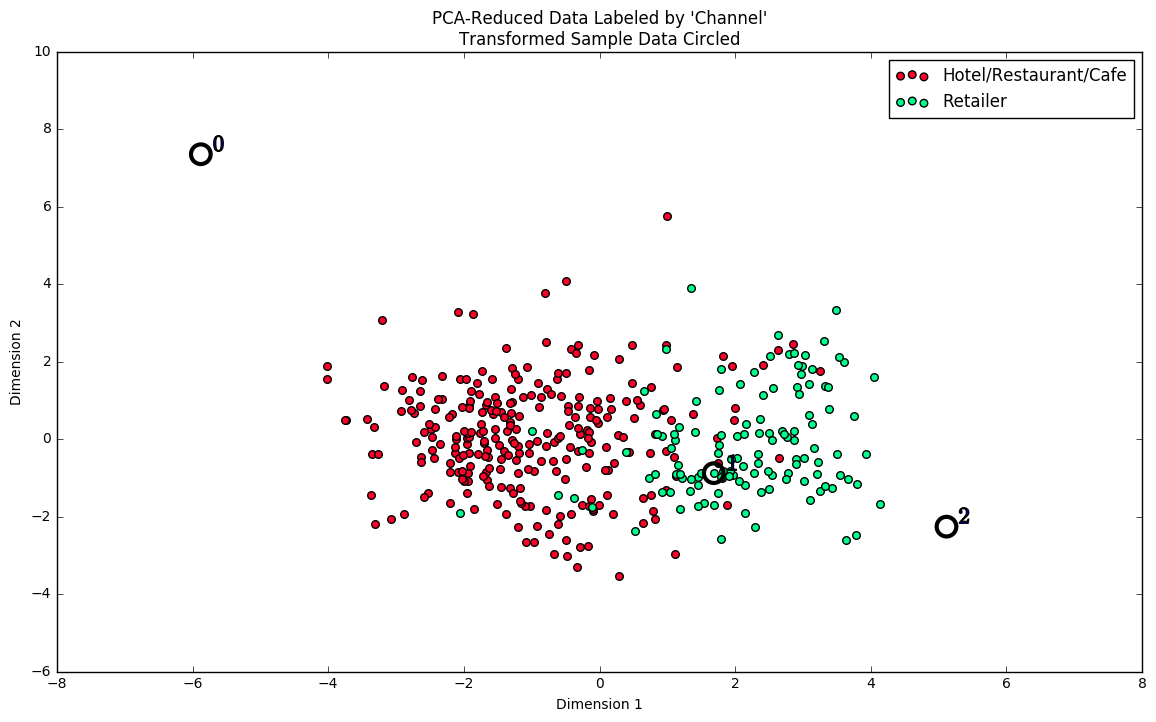

In [40]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:** The findings are consistent and the analysis of which customer segment the sample points are align with the 'Hotel/Restaurant/Cafe' vs 'Retailer' labeling. While there are a few establishments that are moreso part of the other cluster, for the most part the segmentation is accurate. 

While sample points 0 and 2 are on the appropriate sides of the plot, they are both outliers that have been taken out of consideration.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.